**Project : Legal Text Generation Using Recurrent Neural Networks**

**Tech and model used :** *Bi-LSTM implemented using Tensorflow-Keras*

**Character level RNN**

In [0]:
## 201701062
## Dushyant Pathak
## IT-412 - Project - Text Generation using RNN - Implemented using Tensorflow-Keras
## Implementation : Character Level RNN has been implemented as Bi-LSTM Model

In [0]:
## Using tensorboard to view metrics
%load_ext tensorboard

In [0]:
## Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os
import datetime
import time
#from keras import backend as K

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
## Dataset used is Texts of Trade Agreements (ToTA) dataset - Courtesy of Dr William Alschner
## The dataset is a set of 450 XML files in English as well as other languages, written as Bilateral treaties.
## The data has been compiled into a single text file, split into 80:20 - Train and test
path_to_file = '/content/drive/My Drive/dataset_1.txt'
path_to_test = '/content/drive/My Drive/test.txt'

In [6]:
## Opening the train file
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
## Vocab is a sorted set of all chars appearing in the train data
## We have used Python set to remove duplication
vocab = sorted(set(text))
print ('Length of train text: {} characters'.format(len(text)))

Length of train text: 37436064 characters


In [7]:
## Opening the test file
test = open(path_to_test, 'rb').read().decode(encoding='utf-8')
print(type(test))
vocab_test = sorted(set(test))
print ('Length of test text: {} characters'.format(len(test)))

<class 'str'>
Length of test text: 797785 characters


Text Vectorization

In [0]:
## Mapping the chars to indices
char2idx = {u:i for i, u in enumerate(vocab)}
## Index 0 - 0th character - Expressed as numpy array
idx2char = np.array(vocab)
## Shows the integer each character in text is mapped to
text_as_int = np.array([char2idx[c] for c in text])

In [9]:
# Shows the mapping
print ('{} ---- Mapped to ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'THE ASSOCIATI' ---- Mapped to ---- > [54 42 39  2 35 53 53 49 37 43 35 54 43]


In [10]:
## Same for test data
ctoi = {u:i for i, u in enumerate(vocab_test)}
i2c = np.array(vocab_test)
t_as_i = np.array([ctoi[c] for c in test])
print(t_as_i)

[50 38 35 ... 42  1  1]


The task of prediction : 

RNNs maintain an internal state, and thus, can 'remember' previously seen characters.

Thus, given all the characters so far, what is the next most probable character?

Dividing text into example senteces of size seq_length

In [0]:
## The maximum length sentence for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)
## Convert the text vector into a stream of character indices.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)


In [0]:
examples_per_epoch_test = len(test)//(seq_length + 1)
char_dataset_test = tf.data.Dataset.from_tensor_slices(t_as_i)

In [0]:
## Batch converts individual characters into sequences of desired size
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
sequences_test = char_dataset_test.batch(seq_length + 1, drop_remainder = True)

In [0]:
## For each sentence(chunk), duplicate and shift by one to form main->target. 
## Use map function to map these
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [0]:
## Similarly for test dataset
dataset_test = sequences_test.map(split_input_target)

In [0]:
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = dataset_test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [0]:
## Building the model
## We use
##  1. Embedding : Input layer -> Maps char to vector
##  2. LSTM/GRU : RNN 
##  3. Dense : Output layer
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
                               
    ## Comment the LSTM function, and uncomment the following 
    ## GRU function to see a GRU based implementation
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
  
    # tf.keras.layers.GRU(rnn_units,
    #                     return_sequences=True,
    #                     stateful=True,
    #                     recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [0]:
## Building the model

model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [20]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 429) # (batch_size, sequence_length, vocab_size)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           109824    
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 429)           439725    
Total params: 5,796,525
Trainable params: 5,796,525
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Sampling to get actual character indices
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [23]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'ssible in cases to which paragraph 4 applies the Community or Albania, as the case may be, shall sup'

Next Char Predictions: 
 '�–+€тч‟юäND"ώЛΣξ½明，ᏳIϾ㸬\u200b̉αв.!ÐQīüTč?kΛ脚Л脚¼ßå⊥dϾ!ęxо\u200b\uf8e7JAÞић（�η^Å>Сψ■̖‟明Xć脚º¼æ¥w{ћιù°§FΤυеϿÀї̈λØAτżlÇ´'


In [24]:
## We use the categorical_crossentropy function as it is applied across the last dimension of
## the prediction
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
#loss = example_batch_loss.numpy().mean()
print("scalar_loss: ", example_batch_loss.numpy().mean())
print("Perplexity: ", tf.exp(example_batch_loss.numpy().mean()))

Prediction shape:  (64, 100, 429)  # (batch_size, sequence_length, vocab_size)
scalar_loss:  6.061134
Perplexity:  tf.Tensor(428.86142, shape=(), dtype=float32)


In [0]:
## Compiling the model with metric as accuracy
## What accuracy in this use case means, that how accurately can the model predict the next letter.
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [0]:
EPOCHS = 20
## Uncomment to view TensorBoard analytics - This might result in errors, since the tensorboard works only after fitting to the model. 
## In such a case, please restart runtime. 

## log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
## tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
## history_for_tf = model.fit(dataset, epochs=EPOCHS, callbacks=[tensorboard_callback])
## %tensorboard --logdir logs/fit

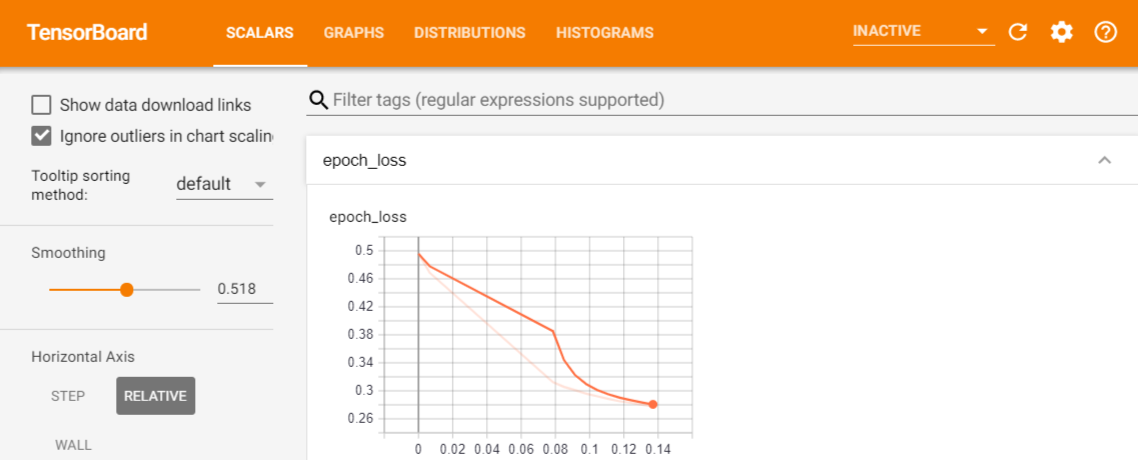

In [28]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
tf.train.latest_checkpoint(checkpoint_dir)

Epoch 1/20
5791/5791 [==============================] - 381s 66ms/step - loss: 1.0619 - accuracy: 0.6966
Epoch 2/20
5791/5791 [==============================] - 383s 66ms/step - loss: 0.7903 - accuracy: 0.7703
Epoch 3/20
5791/5791 [==============================] - 382s 66ms/step - loss: 0.7337 - accuracy: 0.7870
Epoch 4/20
5791/5791 [==============================] - 380s 66ms/step - loss: 0.7031 - accuracy: 0.7964
Epoch 5/20
5791/5791 [==============================] - 379s 66ms/step - loss: 0.6835 - accuracy: 0.8024
Epoch 6/20
5791/5791 [==============================] - 378s 65ms/step - loss: 0.6701 - accuracy: 0.8067
Epoch 7/20
5791/5791 [==============================] - 381s 66ms/step - loss: 0.6603 - accuracy: 0.8096
Epoch 8/20
5791/5791 [==============================] - 380s 66ms/step - loss: 0.6532 - accuracy: 0.8118
Epoch 9/20
5791/5791 [==============================] - 378s 65ms/step - loss: 0.6478 - accuracy: 0.8135
Epoch 10/20
5099/5791 [=========================>....] 

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           109824    
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (64, None, 429)           439725    
Total params: 5,796,525
Trainable params: 5,796,525
Non-trainable params: 0
_________________________________________________________________


Choosing a start string, initializing the RNN state and setting the number of characters to generate.

Get the prediction distribution of the next character using the start string and the RNN state.

Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 10000  

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

      a = (start_string + ''.join(text_generated))
  return a

In [32]:
output_file = open('output.txt','w+')
t = generate_text(model, start_string=u"The government: ")
output_file.write(t)
vocab_output = sorted(set(t))
output_file.close() 

from google.colab import files
files.download('output.txt') 

KeyboardInterrupt: ignored

**Customized Training**

In [0]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()

In [0]:
## print(type(model))
## GradientTape is used to track gradients
## 1. Initialize RNN state using reset_states
## 2. Iterate by batch and calculate the predictions
## 3. Use GradientTape for predictions and loss
## 4. Calculate the gradients of the loss with respect to the model variables
## 5. Apply the gradients using Adam optimizer
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    #fin_pred = predictions
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss


In [36]:
# Training step
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    predictions = model(inp)
    loss = train_step(inp, target)
    ppl = tf.exp(loss)
    prediction = tf.dtypes.cast(predictions, tf.float32)
    
    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {} PPL {} '
      print(template.format(epoch+1, batch_n, loss, ppl))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f} PPL : {:.6f}'.format(epoch+1, loss, ppl))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 6.063162326812744 PPL 429.73223876953125 
Epoch 1 Batch 100 Loss 2.473721742630005 PPL 11.86652946472168 
Epoch 1 Batch 200 Loss 2.17698335647583 PPL 8.819660186767578 
Epoch 1 Batch 300 Loss 1.9486660957336426 PPL 7.019318580627441 
Epoch 1 Batch 400 Loss 1.644035816192627 PPL 5.176016807556152 
Epoch 1 Batch 500 Loss 1.4531952142715454 PPL 4.276757717132568 
Epoch 1 Batch 600 Loss 1.3134865760803223 PPL 3.719118118286133 
Epoch 1 Batch 700 Loss 1.2916754484176636 PPL 3.638878107070923 
Epoch 1 Batch 800 Loss 1.1891993284225464 PPL 3.2844505310058594 
Epoch 1 Batch 900 Loss 1.1272681951522827 PPL 3.0872111320495605 
Epoch 1 Batch 1000 Loss 1.146621823310852 PPL 3.1475419998168945 
Epoch 1 Batch 1100 Loss 1.0578988790512085 PPL 2.880312919616699 
Epoch 1 Batch 1200 Loss 1.1284703016281128 PPL 3.0909247398376465 
Epoch 1 Batch 1300 Loss 1.1280745267868042 PPL 3.0897016525268555 
Epoch 1 Batch 1400 Loss 1.0476597547531128 PPL 2.8509714603424072 
Epoch 1 Batch 1500 Lo

In [37]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  for (batch_n, (inp, target)) in enumerate(dataset_test):
      predictions = model(inp)
      loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
      ppl = 2**loss
    

      if batch_n % 100 == 0:
        template = 'Epoch {} Batch {} Loss {} PPL {}'
        print(template.format(epoch+1, batch_n, loss, 2**loss))

Epoch 1 Batch 0 Loss 10.047724723815918 PPL 1058.440673828125
Epoch 1 Batch 100 Loss 9.364052772521973 PPL 658.962646484375
Epoch 2 Batch 0 Loss 9.362037658691406 PPL 658.0428466796875
Epoch 2 Batch 100 Loss 9.17358684539795 PPL 577.4638061523438
Epoch 3 Batch 0 Loss 9.317740440368652 PPL 638.1449584960938
Epoch 3 Batch 100 Loss 9.308002471923828 PPL 633.8521728515625
Epoch 4 Batch 0 Loss 9.18478012084961 PPL 581.9616088867188
Epoch 4 Batch 100 Loss 9.172714233398438 PPL 577.1146850585938
Epoch 5 Batch 0 Loss 9.312122344970703 PPL 635.6648559570312
Epoch 5 Batch 100 Loss 9.171987533569336 PPL 576.8240356445312
Epoch 6 Batch 0 Loss 9.230301856994629 PPL 600.6171264648438
Epoch 6 Batch 100 Loss 9.24749755859375 PPL 607.8187866210938
Epoch 7 Batch 0 Loss 9.238277435302734 PPL 603.9467163085938
Epoch 7 Batch 100 Loss 9.224835395812988 PPL 598.3456420898438
Epoch 8 Batch 0 Loss 9.323156356811523 PPL 640.545166015625
Epoch 8 Batch 100 Loss 9.043418884277344 PPL 527.6432495117188
Epoch 9 Batc

In [38]:
#calculating Jaccard distance between Output and Test datas
ctoi_output = {u:i for i, u in enumerate(vocab_output)}
t_as_i_output = np.array([ctoi_output[c] for c in t])
b = set(t_as_i.tolist())
a = set(t_as_i_output.tolist())
import nltk
print("Jaccard distance between output and test:", nltk.jaccard_distance(a, b) )


Jaccard distance between output and test: 0.3076923076923077
